<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/Stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [2]:
stock = Stock('005930')

In [3]:
price_df = stock.get_price('20170419')
price_df

,Open,High,Low,Close,Volume
Date,,,,,
2017-04-19,41299,41420,40900,40900,235258
2017-04-20,40580,40800,40080,40280,422977
2017-04-21,40480,41400,40480,40760,302610
2017-04-24,41260,41260,40920,41240,179803
2017-04-25,41460,42740,41320,42700,385992
...,...,...,...,...,...
2021-05-14,79000,80300,78900,80100,16450920
2021-05-17,80800,80900,79200,79600,17740855
2021-05-18,79600,80000,79100,79600,17494407


In [4]:
fundamental_df = stock.get_fundamental()
fundamental_df

,2018.12(Y),2019.12(Y),2020.12(Y),2021.12(E)(Y),2020.03(M),2020.06(M),2020.09(M),2020.12(M),2021.03(M),2021.06(E)(M)
sales,2437714.00,2304009.00,2368070.00,2670000.00,553252.00,529661.00,669642.00,615515.00,653885.00,623502.00
operating profit,588867.00,277685.00,359939.00,487464.00,64473.00,81463.00,123532.00,90470.00,93829.00,106041.00
net income,443449.00,217389.00,264078.00,365706.00,48849.00,55551.00,93607.00,66071.00,71417.00,78204.00
operating margin,24.16,12.05,15.20,18.26,11.65,15.38,18.45,14.70,14.35,17.01
net margin,18.19,9.44,11.15,13.70,8.83,10.49,13.98,10.73,10.92,12.54
roe,19.63,8.69,9.98,13.11,8.45,8.49,9.51,9.98,10.79,NaN
debt ratio,36.97,34.12,37.07,NaN,34.19,32.67,36.09,37.07,43.23,NaN
quick ratio,204.12,233.57,214.82,NaN,237.80,250.04,229.69,214.82,192.26,NaN
reserve ratio,27531.92,28856.02,30692.79,NaN,29134.12,29477.97,30242.29,30692.79,30135.47,NaN
eps,6024.00,3166.00,3841.00,5340.00,720.00,808.00,1364.00,949.00,1044.00,1098.00


In [5]:
from dateutil import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, price_df, fundamental_df):
    self.price_df = price_df
    self.fundamental_df = fundamental_df
    self.mixed_df = self.get_mixed_df()

  def find_date(self, year, month):
    # 결산일 고려 (2달)
    year,month = int(year), int(month)
    next = datetime.date(year,month,1) + relativedelta.relativedelta(months=2)
    year, month = next.year, next.month

    start = str(year) + '-' + str(month) + '-' + '01'
    end = str(year) + '-' + str(month) + '-' + '20'
    return self.price_df.loc[start:end].index.values[0]

  def get_mixed_df(self):
    price_dic = {}
    cnt = 0
    for i in [(x[:4], x[5:7]) for x in self.fundamental_df.columns.values]:
      try:
        price_dic[self.fundamental_df.columns.values[cnt]] = price_df.loc[self.find_date(i[0],i[1])]['Close']
      except:
        price_dic[self.fundamental_df.columns.values[cnt]] = 0
      cnt+=1
    return self.fundamental_df.append(pd.DataFrame(data=price_dic,  index = ['Price']))

  def get_heatmap(self):
    # correlation heatmap
    corrmat = self.mixed_df.transpose().corr().abs() 
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat, annot = True)

  def get_influential(self, num=6):
    return self.get_mixed_df().transpose().corr()['Price'].sort_values(ascending = False).head(num)

In [6]:
analyser = Analyser(price_df, fundamental_df)

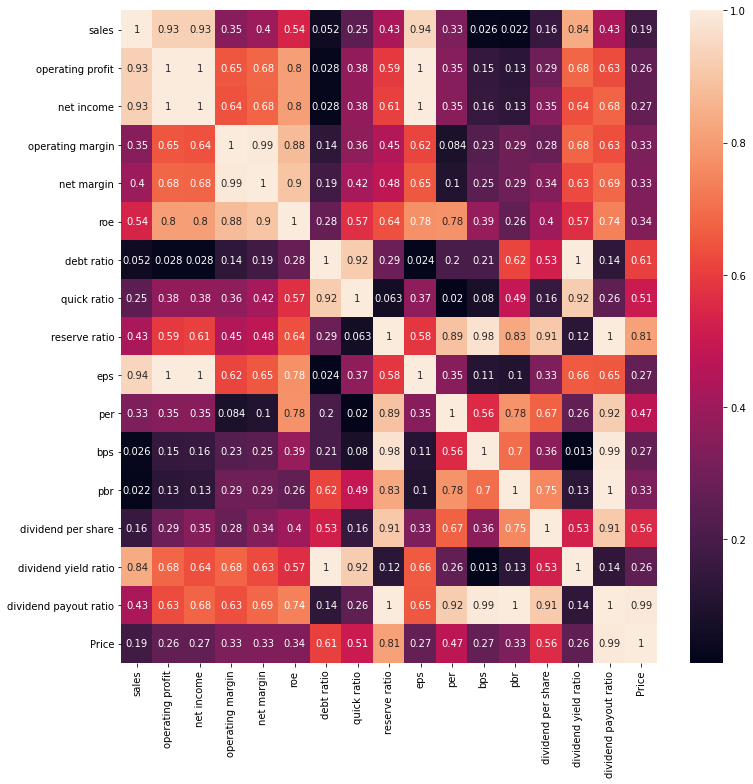

In [7]:
analyser.get_heatmap()

In [8]:
analyser.get_influential()[1:]

dividend payout ratio    0.992268
reserve ratio            0.812559
debt ratio               0.609394
dividend per share       0.560131
pbr                      0.329353
Name: Price, dtype: float64